# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Downloading needed dependencies](#dependencies)
* [Data](#data)
  * [Download Data](#download)
  * [Data wrangling](#wrangling)
* [Methodology](#methodology)
  * [Define Foursquare Credentials and Version](#credentials)
  * [Exploratory data analysis](#analysis)
  * [Find out Tallinn coordinates](#coordinates)
  * [Add districts layer on the map](#maps)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Objective of this project is to understand which district is mostly favoured for living by **families in Tallinn**(capital of Estonia) and analyse what are possible causes. For example does families with children choose to live in a district with lots of outdoor activity opportunities like parks and playgrounds or their choice of residential location is driven by conviniently located schools and kindergardens.

 I will analyse which **districts have highest share of families** residing and look into venues categories, to **understand in what category most venues fall in districts where large number of families prefere living.** After that I will look closely into most popular categories which venues are more common.
 
 To find out if **frequent venue categories** could be reason why **most families** chose to leave in the very same district I will check **corralation** between them.
 

## Downloading needed dependencies <a name="dependencies"></a>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

!conda install -c conda-forge shapely --yes

from shapely.geometry import Point, LineString, Polygon
from shapely.geometry.polygon import Polygon

from io import StringIO

import os
import types
import pandas as pd
from botocore.client import Config
# import ibm_boto3

import seaborn as sb

import math

def __iter__(self): return 0

print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\marim\Anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |   py37hc8dfbb8_1         3.1 MB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.7-1_cp37m

The following packages will be UPDATED:

  conda                                        4.8.2-py37_0 --> 4.8.3-py37hc8dfbb8_1




conda-4.8.3          | 3.1 MB    |            |   0% 
conda-4.8.3          | 3.1 MB    | ####9      |  50% 
conda-4.8.3          | 3.1 MB    | ########## | 100% 

python_abi-3.7

## Data <a name="data"></a>

### Download Data <a name="download"></a>

For analysis I will need information about families and venues by districts. 

* From State Statistical Central Bureau  I was able to retrieve data about **families by place of residence** from population and housing census (kpis.csv).

 This data will be used to analyse share of families and families with children residing in each district.


* From Wikipedia I was able to gather data about **Areas of districts and their coordinates** (District.csv)

 This data mainly will be used to display districts on maps, also for some calculations.

* From Land Board geoportal I was able to get shape file consisting **Tallinn districts**, which was later converted to **geojson** using QGIS software. (tallinn_districts.geojson)

 Geojson will be used for displaying districts on maps, also for analizing vebue locations.


* In addition I will be using **foursquare for venues** data which will be below in seperate section.

 Data about venues will be analyzed for each district by their categories and more in details in accordience with family numbers.
 
I have stored these data into files in github, below I'm accessing them, downloading and putting into dataframes.

In [2]:
# assumes data files are uploaded to git
data_urls = {
    'tallinn_districts': 'https://raw.githubusercontent.com/Marimais/Coursera_Capstone/master/data/tallinn_districts.geojson',
    #'postal_codes': 'https://raw.githubusercontent.com/Marimais/Coursera_Capstone/master/data/sihtnumbrid.csv',
    'kpis': 'https://raw.githubusercontent.com/Marimais/Coursera_Capstone/master/data/kpis.csv',
    'districts': 'https://raw.githubusercontent.com/Marimais/Coursera_Capstone/master/data/District.csv'
}
data = {}
for name, url in data_urls.items():
    result = requests.get(url)
    if url.endswith('json'):
        data[name] = result.json()
    else:
        data[name] = result.text
    print(f'Downloaded {name} with content size {len(result.text)}')

Downloaded tallinn_districts with content size 461514
Downloaded kpis with content size 3689
Downloaded districts with content size 399


In [3]:
# create dataframes
df_areas = pd.read_csv(StringIO(data['districts']))
df_areas.head()

,District,Latitude,Longitude,Area
0,..Haabersti city district,59.4267,24.6313,18.60
1,..Kesklinna city district,59.4328,24.7629,30.60
2,..Kristiine city district,59.4164,24.7100,9.40
3,..Lasnamäe city district,59.4293,24.8352,30.00
4,..Mustamäe city district,59.4010,24.6945,8.15


In [4]:
# create dataframes
df_districts = pd.read_csv(StringIO(data['kpis']))
df_districts.head()

,DIM1,Place of residence,DIM2,Indicator,Value,Flag Codes,Flags
0,176,..Haabersti city district,N1,Number of families,12257.0,NaN,NaN
1,176,..Haabersti city district,N2,Number of family members,33133.0,NaN,NaN
2,176,..Haabersti city district,N3,Average size of family,2.7,NaN,NaN
3,176,..Haabersti city district,N4,Population,41694.0,NaN,NaN
4,176,..Haabersti city district,N5,Share of population living in families,79.5,NaN,NaN


### Data wrangling <a name="wrangling"></a>

Data from the State Statistical Central Bureau contained certain **unnecessary flag columns**, that I'm removing below. 

Also district names where containing **extra charachters** '..' and **unnecessary text** 'city district' which is below trimed. For convinience I **changed the column name** containing spaces to a more lacon version from 'Place of residence' to 'District'.

In geojson district names were containing extra word **'linnaosa'**(district in Estonian) which I'm also **removing**.

I also checked if there were any **null values**, which luckily was not the case.

In [5]:
# delete extra collummns and flags
df_districts.drop(['DIM1', 'DIM2','Flag Codes','Flags'], axis=1, inplace =True)
df_districts.head(2)

,Place of residence,Indicator,Value
0,..Haabersti city district,Number of families,12257.0
1,..Haabersti city district,Number of family members,33133.0


In [6]:
# rename column'Place of residence' as District
df_districts=df_districts.rename(columns={'Place of residence': 'District'})
df_districts.head(2)

,District,Indicator,Value
0,..Haabersti city district,Number of families,12257.0
1,..Haabersti city district,Number of family members,33133.0


In [7]:
# remove extra charachers and text from column 'District'
df_districts['District'] = df_districts['District'].map(lambda x: x.lstrip('.'))
df_districts['District'] = df_districts['District'].str.replace('city district','')
df_districts['District'] = df_districts['District'].str.strip()


df_areas['District'] = df_areas['District'].map(lambda x: x.lstrip('.'))
df_areas['District'] = df_areas['District'].str.replace('city district','')
df_areas['District']=df_areas['District'].str.strip()
df_districts.head(2)

,District,Indicator,Value
0,Haabersti,Number of families,12257.0
1,Haabersti,Number of family members,33133.0


In [8]:
# modify geojson to shorten district names, eg. replace 'Haabersti linnaosa' with just 'Haabersti'
for i, feature in enumerate(data['tallinn_districts']['features']):
    data['tallinn_districts']['features'][i]['properties']['ANIMI']=data['tallinn_districts']['features'][i]['properties']['ANIMI'].replace(' linnaosa', '')
    

In [9]:
# check if any values are Nan
print("number of NaN values for the df_districts :", df_districts.isnull().sum())
print("number of NaN values for the df_districts :", df_areas.isnull().sum())

number of NaN values for the df_districts : District     0
Indicator    0
Value        0
dtype: int64
number of NaN values for the df_districts : District     0
Latitude     0
Longitude    0
Area         0
dtype: int64


## Methodology<a name="methodology"></a>


As goal is to understand which are desirable  **districts  in Tallinn that families choose to live** and whether there is any certain type of **venues that might be reason for such choice**, first I will do analysis to find out which are those district.In the beginning I will show which districts have high population and density(population/area), then I will show what is the share of families out of them. 

As not all families are with children, the motive for choosing residential area with certain type of neighbouring venues might differ. For example families with children might prefer to live near school or soccer filed, while families without children might prefer to live near shopping center or gym. Due to that bellow families with children will be separately analysed. I will show if **families with children** has **correlation with different venue categories** compared to entire **share of families** in general.

For understanding which type of **venues are more common within each district**, first I will group them by categories for analysis and later I will look into relevant sub-categories.

Finally I will try to find if there is and then what kind of **correlation between share of families(with children or without) and certain venue categories.** I might not show below all charts for every category, I will only show ones that seem more relevant. 

So to sum up shortly first I will analyze population distribution within Tallinn districts and share of families out of them, then I will analyse  venue categories and finally I will try to find correlations. 


### Define Foursquare Credentials and Version<a name="credentials"></a>

I'm using Foursquare API to get **venues for Tallinn** districts. As certain venues has more value for families than others I will be filtering them out and comparing which district has most number of such venues and how it corralates with families residing in that district.  

Below I'm conecting to Foursquare API and **creating function to use it for each Tallinn's districts.** To understand exactly in which district which venue is located I'm checking venue location point (lat,long) in which district polygon it falls. It would have been easier to use postcodes of venues to district post codes but unfortunately for Tallinn Foursquare didn't provide such data.

I'm also creating list of category groups with categoryId's for get request.

In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
CLIENT_ID = 'R2DI0ES2KM4GH4BJFR1AY102DHGGAF4WPBGTITH5BCRE0HV5' # your Foursquare ID
CLIENT_SECRET = 'HYUY25VXAZXK4XHSQCBOVQLR50APA4DCIIDJMFH0EPQ2ICC4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [12]:
# defining function for Foursquare API get request 
# by default categoryId is for Outdoors & Recreation
def getNearbyVenues(names, latitudes, longitudes, radius=3000, LIMIT=100,offset = 0, categoryId='4d4b7105d754a06377d81259'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            offset,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Venue', 
                  'Lat', 
                  'Lng', 
                  'Category']
    
    return(nearby_venues)

In [13]:
# Venue categories

d = {'Categories': ['Outdoors & Recreation','School','Residence','Shop & Service','Travel & Transport'], 'Id': ['4d4b7105d754a06377d81259','4bf58dd8d48988d13b941735','4e67e38e036454776db1fb3a','4d4b7105d754a06378d81259','4d4b7105d754a06379d81259']}
df_categories = pd.DataFrame(data=d)

o = {'Categories': ['Playground','Trail','Park','Bike Trail','Soccer Field','Stadium'], 'Id': ['4bf58dd8d48988d1e7941735','4bf58dd8d48988d159941735','4bf58dd8d48988d163941735','56aa371be4b08b9a8d57355e','4cce455aebf7b749d5e191f5','4bf58dd8d48988d184941735']}
df_play_cat=pd.DataFrame(data=o)


### Exploratory data analysis <a name="analysis"></a>

Below I try to understand how **district population, number of families and family friendly venues corralate**.

I will be finding out Density of districts - number of persons per square kilometer within districs area(km2).



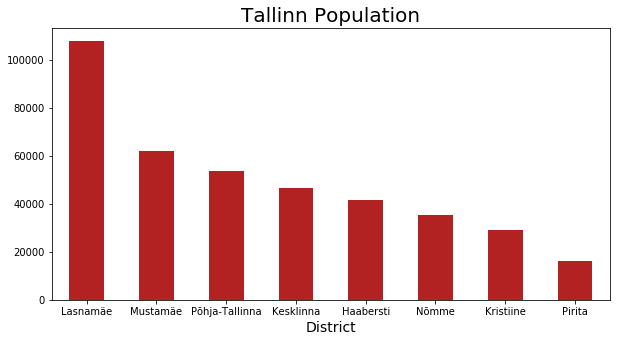

In [14]:
# finding out which district has higher population & Area , and if it corralates positively
df_districts[df_districts.Indicator=='Population'].groupby('District')['Value'].sum().sort_values( ascending  = False).plot.bar(figsize=(10,5), color="firebrick")
plt.title('Tallinn Population', fontsize = 20)
plt.xlabel('District', fontsize = 14)
plt.xticks(rotation = 'horizontal')
plt.show()

C:\Users\marim\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


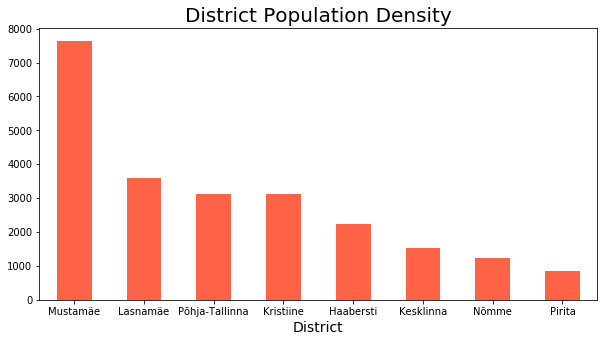

In [15]:
# Density of districts
#  Number of persons per square kilometer within districs,  area(km2) 

df_density=pd.DataFrame()
df_density=df_areas[['District','Area']]

#add Population column
df_temp=pd.DataFrame()
df_temp=df_districts[df_districts.Indicator=='Population']
df_density['Population'] = df_density['District'].map(df_temp.set_index('District')['Value']) 

#calculate density in new column
df_density['p/km2']=round(df_density.Population/df_density.Area,1)
df_density.sort_values(by=['p/km2'], ascending  = False)

#plot
df_density.groupby('District')['p/km2'].sum().sort_values( ascending  = False).plot.bar(figsize=(10,5), color="tomato")
plt.title('District Population Density', fontsize = 20)
plt.xlabel('District', fontsize = 14)
plt.xticks(rotation = 'horizontal')
plt.show()


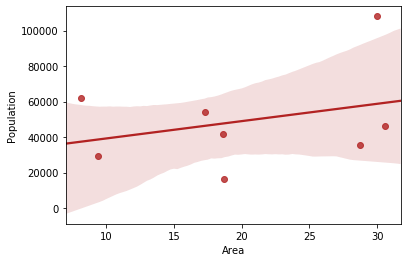

In [16]:
#  check if district area positively coralates with population
rp=sb.regplot(x=df_density['Area'], y=df_density['Population'], color="firebrick")

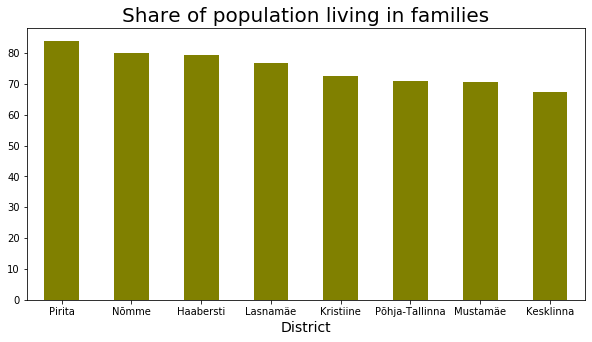

In [17]:
# sorting districts by share of population living in families
df_districts[df_districts.Indicator=='Share of population living in families'].groupby('District')['Value'].sum().sort_values( ascending  = False).plot.bar(figsize=(10,5), color="olive")
plt.title('Share of population living in families', fontsize = 20)
plt.xlabel('District', fontsize = 14)
plt.xticks(rotation = 'horizontal')
plt.show()

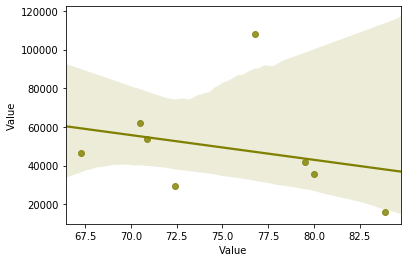

In [18]:
# check if Share of population living in families positively corralates with entire district population
rp=sb.regplot(x=df_districts[df_districts.Indicator=='Share of population living in families'].Value, y=df_districts[df_districts.Indicator=='Population'].Value, color= "olive")

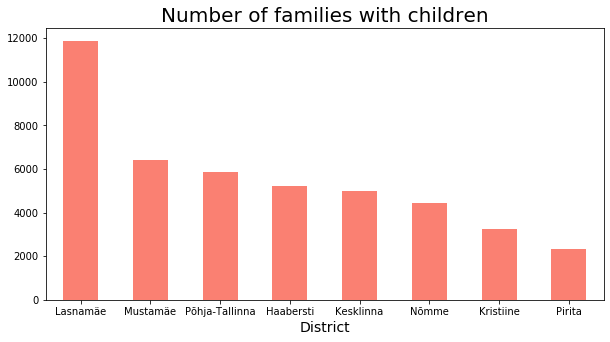

In [19]:
# sorting districts by number of families with children
df_districts[df_districts.Indicator=='Number of families with children aged under 18'].groupby('District')['Value'].sum().sort_values( ascending  = False).plot.bar(figsize=(10,5), color="salmon")
plt.title('Number of families with children', fontsize = 20)
plt.xlabel('District', fontsize = 14)
plt.xticks(rotation = 'horizontal')
plt.show()

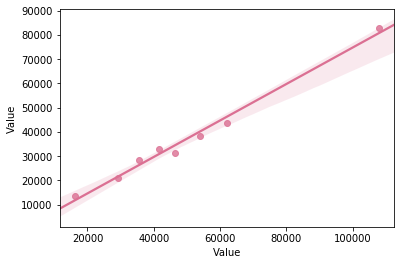

In [20]:
# check if number of family members positively coralates with population
rp=sb.regplot(x=df_districts[df_districts.Indicator=='Population'].Value, y=df_districts[df_districts.Indicator=='Number of family members'].Value, color="palevioletred")

------------------------------

District **area and population has low positive corralation.** Most **densly populated** district in Tallin appears to be **Mustamäe** district, while **highest share of families are residing in Pirita district**. However **most families with children live in Lasnamäe** district followed by Mustamäe on second.


It seems that **district population leaving in families has no corralation with entire district population.** However **size of families(by number of members) positively corralate with district population.**


I will consetrate on districts with highest share of population living in families while making analysis which are : Pirita, Nõmme and Habersti.
Pirita has least population compared to other districts, but most share of people lives in families. Nõmme is close second and Haabersti average.

Lasnamäe and Mustamäe has bigest population and are most densly populated districs. Therefore share of population living in families is rather lower, but they still have most number of families with children.

--------------------------------

To understand **what venues are popular for families and families with children** below I used above defined function and check districts for each category group. 

I am removing duplicates from populated dataframe as radius was set high and to make sure that each venue is registered for correct district I will check venue point (lat, lng) against district polygon. 

Eventualy I analysed which category group of venues are more freaqunt in deistricts. 

---------------------------

In [21]:
# Now let's generate new dataframe with venues with general categories for each district
district_venues = pd.DataFrame()

for index, cat in df_categories.iterrows():
    print (cat['Categories'])
    district_venues_temp = getNearbyVenues(names=df_areas['District'],
                                   latitudes=df_areas['Latitude'],
                                   longitudes=df_areas['Longitude'],
                                   categoryId = cat[1]
                                  )
    district_venues_temp['Category_group']=cat['Categories']
    district_venues=district_venues.append(district_venues_temp, ignore_index=True)
    print("\n")


Outdoors & Recreation
Haabersti
Kesklinna
Kristiine
Lasnamäe
Mustamäe
Nõmme
Pirita
Põhja-Tallinna


School
Haabersti
Kesklinna
Kristiine
Lasnamäe
Mustamäe
Nõmme
Pirita
Põhja-Tallinna


Residence
Haabersti
Kesklinna
Kristiine
Lasnamäe
Mustamäe
Nõmme
Pirita
Põhja-Tallinna


Shop & Service
Haabersti
Kesklinna
Kristiine
Lasnamäe
Mustamäe
Nõmme
Pirita
Põhja-Tallinna


Travel & Transport
Haabersti
Kesklinna
Kristiine
Lasnamäe
Mustamäe
Nõmme
Pirita
Põhja-Tallinna




In [22]:
#removing duplicates due to areas can intersect, because radius was set high
district_venues=district_venues.drop_duplicates()
district_venues=district_venues.reset_index()
district_venues.shape

(1448, 6)

In [23]:
#To understand which district venue belongs to venue point(lat,lon) is searched in district plygon
for index, venue in district_venues.iterrows():
    point = Point(venue['Lng'], venue['Lat'])
    for i, feature in enumerate(data['tallinn_districts']['features']):
        multipoly = data['tallinn_districts']['features'][i]['geometry']['coordinates']
        district_name = data['tallinn_districts']['features'][i]['properties']['ANIMI']

        for j, poly in enumerate(multipoly):
            polygon = Polygon(poly[0])
            if polygon.contains(point):
                district_venues.loc[district_venues.index[index], 'District'] = district_name

district_venues.shape

(1448, 7)

In [24]:
# Grouping venues by catgories and districs (ignoring sub categories at this point)
grouped = district_venues.groupby(['District','Category_group'])

In [25]:
#create new dataframe with top 5 categories for each district
df_categories=pd.DataFrame()
df_categories=district_venues[['Venue','Category_group', 'District']].groupby(['Category_group','District']).agg([ 'count']).reset_index()
df_categories.columns=['Category_group','District','Count']

df_popular= pd.DataFrame()

for d in df_areas.District:
    df_popular=df_popular.append(df_categories[df_categories.District==d].sort_values(by=['District','Count'], ascending  = False).head(), ignore_index=True)
df_popular.head()

,Category_group,District,Count
0,Shop & Service,Haabersti,73
1,Travel & Transport,Haabersti,29
2,Outdoors & Recreation,Haabersti,28
3,School,Haabersti,7
4,Residence,Haabersti,2


Text(0.5, 0, 'District')

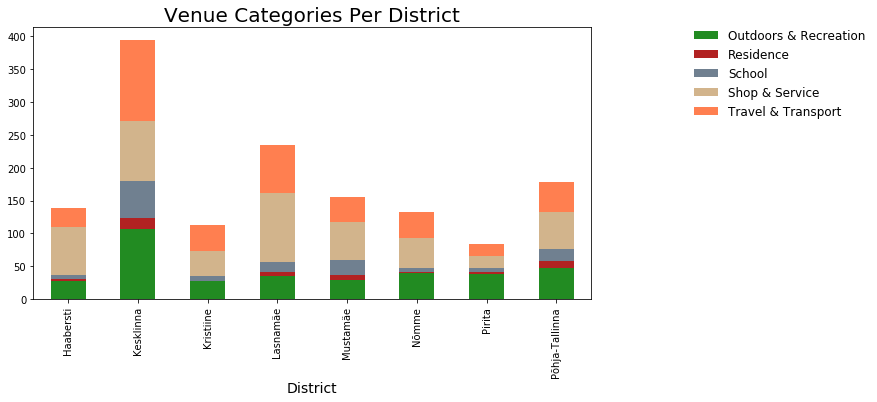

In [26]:
#For better visualization lets put this on stacked bar chart
colors = ["forestgreen", "firebrick","slategrey", "tan","coral"]
pt=df_popular.groupby(['District','Category_group'])['Count'].sum().unstack('Category_group').fillna(0).plot.bar( stacked=True, color=colors, figsize=(10,5))
pt.legend(loc='upper right',  bbox_to_anchor= (1.5, 1.01), borderaxespad=0,frameon=False, fontsize=12)
pt.set_title('Venue Categories Per District', fontsize = 20)
pt.set_xlabel('District', fontsize = 14)


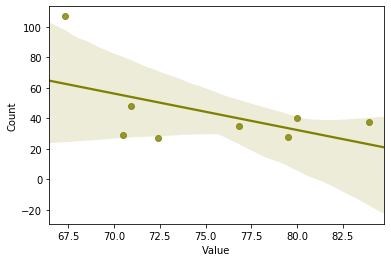

In [27]:
# check if Share of population living in families positively corralates with number of Outdoors & Recreation venues
rp=sb.regplot(x=df_districts[df_districts.Indicator=='Share of population living in families'].Value, y=df_popular[df_popular.Category_group=='Outdoors & Recreation'].Count, color= "olive")

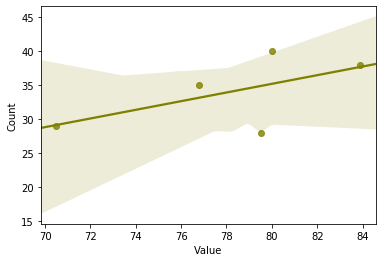

In [51]:
# check if Share of population living in families positively corralates with number of Outdoors & Recreation venues
#Only for districts with high number of families and families with children
rp=sb.regplot(x=df_districts[(df_districts.Indicator=='Share of population living in families') & (df_districts['District'].isin(['Lasnamäe','Mustamäe','Pirita','Haabersti','Nõmme']))].Value, y=df_popular[(df_popular.Category_group=='Outdoors & Recreation') & (df_popular['District'].isin(['Lasnamäe','Mustamäe','Pirita','Haabersti','Nõmme']))].Count, color= "olive")

In [ ]:
# check if Number of families with children  positively corralates with number of School
rp=sb.regplot(x=df_districts[df_districts.Indicator=='Number of families with children aged under 18'].Value, y=df_popular[df_popular.Category_group=='School'].Count, color= "salmon")

In [6]:
# Sorting  venue categories  by frequency
df_popular.groupby(['Category_group'])['Count'].sum().sort_values( ascending  = False)

NameError: name 'df_popular' is not defined

 --------------------------------------


Also **largest number of  venues belong to 'Shop & Service' and 'Travel & Transport' category groups**, however this is case for each district and simply shows entire population needs. As I'm intrested what type of venues can be desireble for families other than basic need of shops and bus stops, **I will further analyse** sub categories of third category group **'Outdoors & Recreation'.**




 -----------------------------------------------------

In [5]:
#Defining new dataframe of 'Outdoors & Recreation' venues
df_or=district_venues[district_venues.Category_group=='Outdoors & Recreation']
df_or.drop(["index"], axis = 1, inplace = True) 
df_or.reset_index(level = 0, inplace = True)


NameError: name 'district_venues' is not defined

In [31]:
grouped = df_or.groupby(['District','Category'])

In [4]:
#Create new dataframe with top 5 venue sub categories for each district
df_categories_or=pd.DataFrame()
df_categories_or=df_or[['Venue','Category', 'District']].groupby(['Category','District']).agg([ 'count']).reset_index()
df_categories_or.columns=['Category','District','Count']

df_popular_or= pd.DataFrame()

for d in df_areas.District:
    df_popular_or=df_popular_or.append(df_categories_or[df_categories_or.District==d].sort_values(by=['District','Count'], ascending  = False).head(), ignore_index=True)
df_popular_or

NameError: name 'pd' is not defined

Text(0.5, 0, 'District')

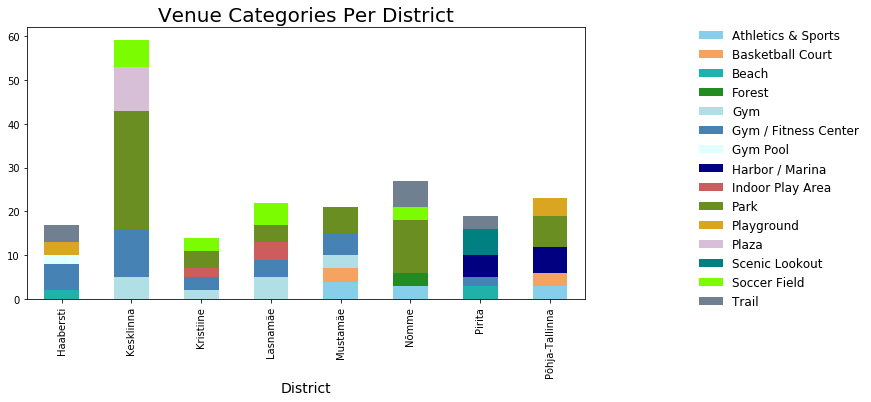

In [146]:
#For better visualization lets put this on stacked bar chart
colors = ["skyblue", "sandybrown","lightseagreen", "forestgreen","powderblue","steelblue","lightcyan","navy","indianred","olivedrab", "goldenrod","thistle","teal", "lawngreen","slategray"]
pt=df_popular_or.groupby(['District','Category'])['Count'].sum().unstack('Category').fillna(0).plot.bar(stacked=True, color=colors, figsize=(10,5))
pt.legend(loc='upper right',  bbox_to_anchor= (1.5, 1.01), borderaxespad=0,frameon=False,fontsize=12)
pt.set_title('Venue Categories Per District', fontsize = 20)
pt.set_xlabel('District', fontsize = 14)


Text(0.5, 0, 'District')

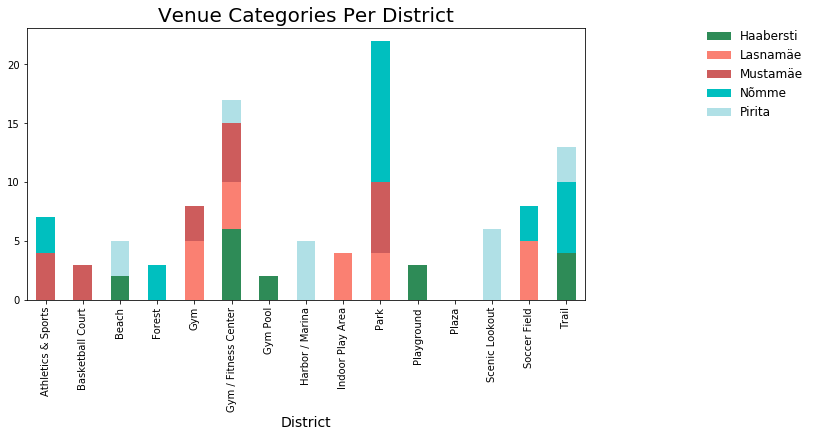

In [165]:

colors = ["seagreen","salmon","indianred", "c", "powderblue"]

df_temp=df_popular_or.groupby(['Category','District'])['Count'].sum().unstack('District').fillna(0)
df_temp=df_temp.drop(['Kesklinna' , 'Kristiine','Põhja-Tallinna',],axis=1)
pt=df_temp.plot.bar(stacked=True, color=colors, figsize=(10,5))
pt.legend(loc='upper right',  bbox_to_anchor= (1.4, 1.01), borderaxespad=0,frameon=False,fontsize=12)
pt.set_title('Venue Categories', fontsize = 20)
pt.set_xlabel('District', fontsize = 14)


 ------------------------------------

Therefore within **districts with  high share of families residing most freaquents venues include Trails, parks and Gyms.**

It's quite similar picture for districts with  **highest number of families with children**, however playing areas such as **soccer and basketball fileds has higher freaquency.**

  -----------------------------------

### Find out Tallinn coordinates <a name="coordinates"></a>

To show on **map** districts with share of families and density of population residing, also to display some additional information for comparision I will be using **folium.**


In [59]:
address = 'Tallinn, Estonia'

geolocator = Nominatim(user_agent="tln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print(f'The geographical coordinate of Tallinn are {latitude}, {longitude}')

# create map of New York using latitude and longitude values
map_Tallinn = folium.Map(location=[latitude, longitude], zoom_start=12)


The geographical coordinate of Tallinn are 59.4372155, 24.7453688


### Add districts layer on the map<a name="maps"></a>

Using folium I will show on **map districts by share of population living in families** and additional information will be shown in markers for comparison.

I will add second **map showing how densly Tallinn districts are populated** so visually can be compared agains share of families distribution.


In [81]:
# Drawing Tallinn map with district layers, weighed by 'Share of population living in families'
data_map = folium.Map(location=[latitude, longitude], zoom_start=12)

df_map=df_districts[df_districts.Indicator=='Share of population living in families']

data_map.choropleth(geo_data=data['tallinn_districts'],
                   data=df_map,
                   columns=['District','Value'],
                   key_on='feature.properties.ANIMI',
                   fill_color='PuBuGn',
                   fill_opacity=0.6,
                   line_opacity=0.8,
                   legend_name='Share of population living in families'
                   )
res = folium.LayerControl().add_to(data_map)

In [89]:
# creating marker with additional information for each District
for i in range(df_areas.shape[0]):
    location = [df_areas['Latitude'][i],df_areas['Longitude'][i]]
    tooltip = "District:{}<br> Click for more".format(df_areas["District"][i])

    folium.Marker(location, # adding more details to the popup screen using HTML
                  popup="""
                  <i>Share of population living in families: </i> <br> <b>{}</b> <br> 
                  <i>Average size of family: </i><b><br>{}</b><br>
                  <i>Number of Outdoors & Recreation venues: </i><b><br>{}</b><br>""".format(
                    round(df_districts[(df_districts.District==df_areas["District"][i]) & (df_districts.Indicator=='Share of population living in families')].Value.values[0],1), 
                    round(df_districts[(df_districts.District==df_areas["District"][i]) & (df_districts.Indicator=='Average size of family')].Value.values[0],1),                      
                    round(df_popular[(df_popular.District==df_areas["District"][i]) & (df_popular.Category_group=='Outdoors & Recreation')].Count.values[0],1)
                  ),
                  icon=folium.Icon(color='salmon', icon='info-sign')).add_to(data_map)
    
data_map  





In [27]:
# Drawing Tallinn map with district layers, weighed by density
latitude, longitude = 59.4250354, 24.7438692605109
data_map = folium.Map(location=[latitude, longitude], zoom_start=12)


data_map.choropleth(geo_data=data['tallinn_districts'],
                   data=df_density,
                   columns=['District','p/km2'],
                   key_on='feature.properties.ANIMI',
                   fill_color='YlOrRd',
                   fill_opacity=0.6,
                   line_opacity=0.7,
                   legend_name='Headcount per square kilometer'
                   )
res = folium.LayerControl().add_to(data_map)
data_map

## Results and Discussion<a name="results"></a>

 As there was no correlation for the entire city's share of population living in families and venue categories, there is a positive trend of correlation for only those neighbourhoods that have a high share of population living in families. Two Tallinn districts were identified as the most popular for families and families with children and venue types have been explored in more detail.
    In the venue category of ‘Outdoors & Recreation’ falls many similar sub-types of venues that could have been categorised together. For example Gym, Gym/Fitness Center and Gym pool are different subcategories but logically they can be grouped together. In report I leave these subcategories as they are in foursquare.
 In analysis I use count of venues, but quantitative evaluation is not sensible for all types of venues. For example It makes sense if families with children will choose neighbourhoods with many playgrounds, but many parks in neighbourhoods are not necessarily an advantage.  Perhaps there is only one park in the district but the area of this park is much larger than the area of many small parks accumulated in the other district. In case it was evident to me that the need of analyzing parks separately would have been beneficial, park area data should have been obtained.  Foursquare doesn’t offer all data for Tallinn unfortunately, as it is not a very popular API here. For example postal index columns were returned empty to me and data was missing in many other columns. Same analyses done using Google API might have given different results, however in this project usage of Foursquare API was mandatory


## Conclusion <a name="conclusion"></a>

In this project I analyzed which Tallinn districts are mostly prefered by families to reside and whether or not there are any certain types of venues that play a role in such distribution. I identified Tallinn districts with highest population density, highest share of families residing and highest  number of families with children under 18. I explored different venue categories in those districts and their relation with family data. For determining an association between these variables an inferential statistical method of correlation has been used.  As there was no correlation for the entire city's share of population living in families and venue categories, there is a positive trend of correlation for only those neighbourhoods that have a high share of population living in families. Two Tallinn districts were identified as the most popular for families and families with children and venue types have been explored in more detail.